In [1]:
#!/usr/bin/env python

# core-exampe-comparison.ipynb

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn
# from mpl_toolkits.basemap import Basemap, cm

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
from draft_functions import core_2d_properties, core_3d_properties, \
                            watersheding, interpolate_obs, remove_noise

In [4]:
# DX = ['500M','250M','125M']
# DT = [2,1,0.5]
# dx_m = [500,250,125] 

DX = ['250M']
DT = [1]
dx_m = [250] 
SIM_All = ['mao_20140401_15:00:00_',
        'mao_20140917_17:00:00_',
        'mao_20141004_13:00:00_',
        'mao_20141018_14:00:00_',
        'mao_20141117_18:00:00_',
        'mao_20141210_14:00:00_',
        'mao_20150328_15:00:00_',
        'mao_20150412_12:00:00_',
        'mao_20150621_14:00:00_',
        'mao_20151106_12:00:00_',
        'sgp_20120531_04:00:00_',
        'sgp_20120615_07:00:00_',
        'sgp_20130509_07:00:00_',
        'sgp_20130605_09:00:00_',
        'sgp_20130617_07:00:00_',
        'sgp_20140602_04:00:00_',
        'sgp_20140605_12:00:00_',
        'sgp_20140612_06:00:00_',
        'sgp_20140628_16:00:00_',
        'sgp_20140710_10:00:00_']
si = 10 #10
SIM = SIM_All[si]
Site = SIM[:3].upper()

vwp_dir_obs = '/glade/campaign/mmm/c3we/prein/Projects/2019_ASR-MCS/data/RWP/' # SGP_RWP/'
vwp_dir = '/glade/campaign/mmm/c3we/mingge/WRF_DOE/virtual_profiler_NetCDF/'
wrfout_dir = '/glade/campaign/mmm/c3we/mingge/WRF_DOE/'

VARS = ['WW','QS','QR','QC','QG','QV','TK','P'] # virtual profiler variables

In [5]:
grDATA = {}
for dx in range(len(DX)):
    vwp_file = vwp_dir + SIM_All[si][:-1] + '/' + DX[dx] + '/'+ SIM_All[si]+ '_'+ DX[dx] +'_Loc01.nc'
    ncfile = Dataset(vwp_file)
    height = np.squeeze(ncfile.variables["Height"])
    time = np.squeeze(ncfile.variables['Time'])
    ncfile.close()
    
    # from datetime import timedelta
    from datetime import datetime, timedelta
    StartDay = datetime(int(SIM[4:8]), int(SIM[8:10]), int(SIM[10:12]), int(SIM[13:15])) - timedelta(hours=6)
    StopDay = StartDay  + timedelta(hours=12)
    rgdTimeMCS = pd.date_range(StartDay, end=StopDay, freq=str(DT[dx])+'s') #'500ms')
    rgdTimeMCS = rgdTimeMCS[:len(time)]

    DATA = np.zeros((len(time),len(height), 20, len(VARS))); DATA[:] = np.nan
    lat_vs = np.zeros((20)); lat_vs[:] = np.nan
    lon_vs = np.copy(lat_vs)

    for lo in tqdm(range(20)):  
        loc = str(lo+1).zfill(2)
        vwp_file = vwp_dir + SIM_All[si][:-1] + '/' + DX[dx] + '/'+ SIM_All[si]+ '_'+ DX[dx] +'_Loc' + loc + '.nc'
        ncfile = Dataset(vwp_file)
        
        lat_vs[lo] = ncfile.getncattr('profiler latitude')
        lon_vs[lo] = ncfile.getncattr('profiler longitude')
        for va in range(len(VARS)):
            # print('    '+VARS[va])
            DATA[:,:,lo,va] = np.squeeze(ncfile.variables[VARS[va]])
        grDATA[DX[dx]] = DATA

100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


In [6]:
# read the propagation speed of the observed MCSs
import xarray as xr
speed_sgp_file = '/glade/campaign/mmm/c3we/prein/Projects/2019_ASR-MCS/data/RWP/obs_movement-speed/sgprwpclsC1.c1.storms.nc'
ds_disk = xr.open_dataset(speed_sgp_file)



In [7]:
ds_disk['base_time'][1,:10]

<xarray.DataArray 'base_time' (time: 10)>
[10 values with dtype=datetime64[ns]]
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 00:00:06 ... 00:00:48 00:00:54
    storm    int32 1
Attributes:
    long_name:  Epoch time

In [8]:
np.where(np.max(DATA[:,:,:,0]) == DATA[:,:,:,0])

(array([6918]), array([32]), array([8]))

In [9]:
rgdTimeMCS[6918]

Timestamp('2012-05-30 23:55:18')

In [10]:
rgdTimeMCS.shape

(42600,)

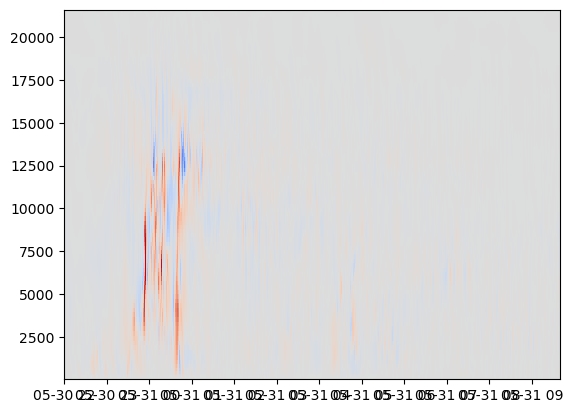

In [11]:
t0 = 0
t1 = 42000
loc = 8
plt.pcolormesh(rgdTimeMCS[t0:t1], height, DATA[t0:t1,:,loc,0].T, vmin=-25, vmax=25, cmap='coolwarm')

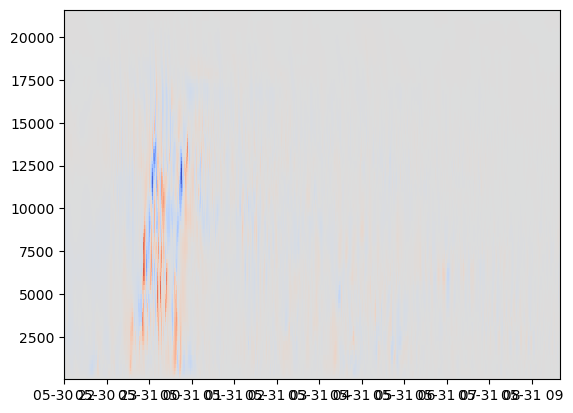

In [12]:
plt.pcolormesh(rgdTimeMCS[t0:t1], height, DATA[t0:t1,:,11,0].T, vmin=-25, vmax=25, cmap='coolwarm')

### Read in dBZ at 20th model leve

In [13]:
wrfout_files = np.sort(glob.glob(wrfout_dir+DX[dx]+'/Thomson_YSU/'+SIM+DX[dx]+'/wrfout_d02*'))
ncfile = Dataset(wrfout_files[0])
lat = np.squeeze(ncfile.variables["XLAT"])
lon = np.squeeze(ncfile.variables['XLONG'])
ncfile.close()

In [14]:
dbz = np.zeros((len(wrfout_files), lat.shape[0], lat.shape[1])); dbz[:] = np.nan
for tt in tqdm(range(len(wrfout_files))):
    ncfile = Dataset(wrfout_files[tt])
    dbz[tt,:,:] = np.squeeze(ncfile.variables["REFL_10CM"][0,20,:,:])
    ncfile.close()

100%|██████████| 72/72 [01:10<00:00,  1.03it/s]


In [15]:
# create time vector for wrfout files
import wrf
ncfile = Dataset(wrfout_files[0])
start_wrfout = wrf.extract_times(ncfile,0)
ncfile = Dataset(wrfout_files[-1])
stop_wrfout = wrf.extract_times(ncfile,0)

time_wrfout = pd.date_range(start_wrfout, end=stop_wrfout, freq='10min') #'500ms')

### Track high-reflectivity areas and determine their speed

In [16]:
idbz_threshold = 40
MinObjVolume = 4000000 # m2
iSmooth = 16000
rgiObj_Struct=np.zeros((3,3,3)); rgiObj_Struct[:,:,:]=1

iSmoothGC=int(iSmooth/dx_m[dx])
dbz_smooth=scipy.ndimage.uniform_filter(dbz[:,:,:],[1,iSmoothGC,iSmoothGC])

# threshold the dbz
rgiTH_dbz=(dbz_smooth >= idbz_threshold)
rgrdbz_thresholded=np.copy(dbz)
rgrdbz_thresholded[rgiTH_dbz == False]=0
rgiObjectsUD, nr_objectsUD = ndimage.label(rgiTH_dbz,structure=rgiObj_Struct)

# sort the objects according to their size
Objects=ndimage.find_objects(rgiObjectsUD)
rgiVolObj=np.array([np.sum(rgiObjectsUD[Objects[ob]] == ob+1) for ob in range(nr_objectsUD)])
rgiObBySize=np.array([np.where(np.sort(rgiVolObj)[::-1][ob] == rgiVolObj)[0][0] for ob in range(nr_objectsUD)])
rgiObBySize=rgiObBySize[rgiVolObj[rgiObBySize] >= MinObjVolume]

# create final object array
dbz_objects=np.copy(rgiObjectsUD); dbz_objects[:]=0
for ob in range(len(rgiObBySize)):
    dbz_objects[rgiObjectsUD == (rgiObBySize[ob]+1)] = ob+1
    


In [17]:
print('        break up long living cores')
from Tracking_Functions import BreakupObjects
MS_objects, object_split = BreakupObjects(dbz_objects,
                            3/6.,
                            1/6.)

        break up long living cores


100%|██████████| 2/2 [00:53<00:00, 26.92s/it]


        00:01:34.00


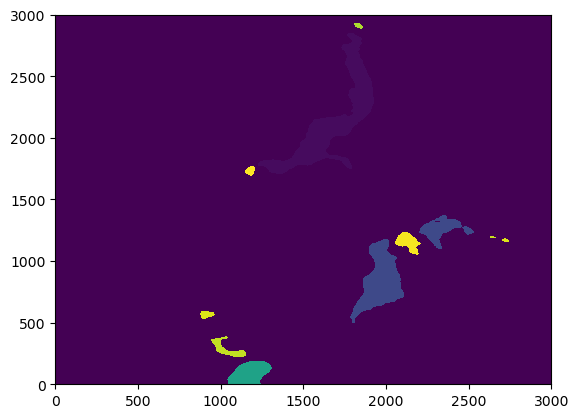

In [18]:
plt.pcolormesh(dbz_objects[35,:,:])

In [19]:
from Tracking_Functions import calc_grid_distance_area
from Tracking_Functions import calc_object_characteristics
_,_,Area,Gridspacing = calc_grid_distance_area(lon,lat)

cell_obj_characteristics = calc_object_characteristics(MS_objects.astype('int'), # feature object file
                                     dbz,         # original file used for feature detection
                                     'tmp/cell_stats.pkl',
                                     rgdTimeMCS,            # timesteps of the data
                                     lat,             # 2D latidudes
                                     lon,             # 2D Longitudes
                                     Gridspacing,
                                     Area,
                                     min_tsteps=3,
                                     split_merge = 0)

            Loop over 45 objects


In [20]:
# get cores that intersect with virtual sounding locations

# get location of vs in grid
from Tracking_Functions import radialdistance
lat_vs_id = np.copy(lat_vs); lat_vs_id[:] = np.nan
lon_vs_id = np.copy(lat_vs_id)
for ii in tqdm(range(len(lat_vs))):
    mindist = radialdistance(lat,lon,lat_vs[ii],lon_vs[ii])
    min_loc = np.argwhere(mindist == np.min(mindist))[0]
    lat_vs_id[ii] = min_loc[0]
    lon_vs_id[ii] = min_loc[1]

lat_vs_id = lat_vs_id.astype('int')
lon_vs_id = lon_vs_id.astype('int')

100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


In [22]:
dist = 60000 # m -- distance to extract arround the station
timewindow = 40 # minutes arround 2D obs
dx_dist = int(dist/dx_m[dx])

cores_vp_up = {}
cores_vp_up_obs = {}
cores_2d_up = {}
cores_3d_up = {}
cores_vp_down = {}
cores_vp_down_obs = {}
cores_2d_down = {}
cores_3d_down = {}

ud_min = 1.5
dd_min = 1.5
draft_th = [1.5,3.0,6.0,10.0]

direction = ['up', 'down']  # [ up - updraft; down - downdraft]

# loop over virtual profilers
for ii in [0]: #tqdm(range(len(lat_vs))):
    conv_inters = np.unique(MS_objects[:,lat_vs_id[ii],lon_vs_id[ii]])[1:]
    la_start = lat_vs_id[ii] - dx_dist
    la_stop = lat_vs_id[ii] + dx_dist + 1
    lo_start = lon_vs_id[ii] - dx_dist
    lo_stop = lon_vs_id[ii] + dx_dist +1

    location = 'loc-'+str(ii).zfill(2)

    # virtual profiler data
    data_vp = grDATA[DX[dx]][:,:,ii,:]

    for ca in range(len(conv_inters)):
        conv_element = 'conv-'+str(ca).zfill(3)
        files_int = wrfout_files[conv_inters[ca] == (MS_objects[:,lat_vs_id[ii],lon_vs_id[ii]])]
        speed_ca_median = np.median(cell_obj_characteristics[str(conv_inters[ca])]['speed'])
        for fi in [0]: #range(len(files_int)):
            file_act = 'output-'+str(fi).zfill(2)
            ncfile = Dataset(files_int[fi])
            dbz_ca = np.squeeze(ncfile.variables["REFL_10CM"][0,:,la_start:la_stop,lo_start:lo_stop])
            w_ca = np.squeeze(ncfile.variables["W"][0,:,la_start:la_stop,lo_start:lo_stop])
            z_ca_stag = (np.squeeze(ncfile.variables["PHB"][0,:,la_start:la_stop,lo_start:lo_stop]) + \
                    np.squeeze(ncfile.variables["PH"][0,:,la_start:la_stop,lo_start:lo_stop])) / 9.81 - \
                    np.squeeze(ncfile.variables["HGT"][0,la_start:la_stop,lo_start:lo_stop])
            z_ca = (z_ca_stag[1:,:] + z_ca_stag[:-1,:])/2
            # brind 3D data to common grid
            dbz_ca_comz = wrf.interpz3d(dbz_ca, z_ca, height, missing = np.nan)
            w_ca_comz = wrf.interpz3d(w_ca, z_ca_stag, height, missing = np.nan)
            ncfile.close()

            # degrees to meters
            lon_m = np.linspace(0,Gridspacing*w_ca.shape[1], w_ca.shape[1]); lon_m = lon_m - np.mean(lon_m)
            lat_m = np.copy(lon_m)

            cloudmask = np.copy(dbz_ca_comz[:,dx_dist,:]); cloudmask[:] = 1
            cloudmask[0,:] = np.nan
            cloudmask[-1,:] = np.nan
            cloudmask[dbz_ca_comz[:,dx_dist,:] <= -30] = np.nan
            
            cloudmask_3d = np.copy(dbz_ca_comz[:,:,:]); cloudmask_3d[:] = 1
            cloudmask_3d[dbz_ca_comz[:,:,:] <= -30] = np.nan

#             plt.pcolormesh(lon_m/1000., height, w_ca_comz[:,dx_dist,:], vmin=-25, vmax=25, cmap='coolwarm')
#             plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] > 5, colors = 'r')
#             plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] < -5, colors = 'b')
#             plt.contour(lon_m/1000., height, 
#                            cloudmask > 0,
#                         colors='k')
#             plt.show()
            
#             stop()

            for di in range(len(direction)):
                if direction[di] == 'up':
                    dire_sign = 1
                elif direction[di] == 'down':
                    dire_sign = -1

                for th in range(len(draft_th)):
                    # WORKING ON 2D CORES
                    updrafts = w_ca_comz[:,dx_dist,:]  * dire_sign > draft_th[th]
                    rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])

                    w_2D = np.copy(w_ca_comz[:,dx_dist,:]) * dire_sign
                    
                    # watershedding
                    # rgiObjectsUD = watersheding(rgiObjectsUD, 
                    #                             w_2D,
                    #      int(4000/dx_m[dx]),
                    #      1)
                    rgiObjectsUD = watersheding(w_2D,
                         int(4000/dx_m[dx]),
                         1)
                    # sort the objects according to their size
                    Objects=ndimage.find_objects(rgiObjectsUD)
                                        
                    if direction[di] == 'up':
                        cores_2d_up[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_2d_properties(Objects,
                                  rgiObjectsUD,
                                      w_2D,
                                      cloudmask,
                                      height,
                                      lon_m)
                    elif direction[di] == 'down':
                        cores_2d_down[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_2d_properties(Objects,
                                  rgiObjectsUD,
                                      w_2D,
                                      cloudmask,
                                      height,
                                      lon_m)

                        
                    #  WORK ON 3D CORES
                    updrafts = w_ca_comz[:,:,:]  * dire_sign > draft_th[th]
                    rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[:,:,:])
                    
                    w_3D = np.copy(w_ca_comz[:,:,:]) * dire_sign
                    w_3D[np.isnan(cloudmask_3d)] = np.nan
                    
                    # watershedding
                    rgiObjectsUD = watersheding(w_3D,
                                                 int(4000/dx_m[dx]),
                                                 1)
                    # sort the objects according to their size
                    Objects=ndimage.find_objects(rgiObjectsUD)

                    rgiObjectsUD = rgiObjectsUD.astype(float)
                    rgiObjectsUD[np.isnan(cloudmask_3d)] = np.nan

                    if direction[di] == 'up':
                        cores_3d_up[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_3d_properties(w_3D,
                                          rgiObjectsUD,
                                          Objects,
                                          height,
                                          lat_m,
                                          lon_m)
                    elif direction[di] == 'down':
                        cores_3d_down[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_3d_properties(w_3D,
                                          rgiObjectsUD,
                                          Objects,
                                          height,
                                          lat_m,
                                          lon_m)

                    
                        
        # ---------------------------------------------
        # calculate properties from virtual profiler
        time_ca = time_wrfout[conv_inters[ca] == (MS_objects[:,lat_vs_id[ii],lon_vs_id[ii]])]
        time_vp = (rgdTimeMCS <= (time_ca + timedelta(minutes=timewindow))[0]) & (rgdTimeMCS >= (time_ca - timedelta(minutes=timewindow))[0])  
        time_to_length = range(0,sum(time_vp), DT[dx]) * speed_ca_median

        wrf_dbz_column = wrf.dbz(data_vp[time_vp,:,VARS.index('P')][None,:], 
                        data_vp[time_vp,:,VARS.index('TK')][None,:], 
                        data_vp[time_vp,:,VARS.index('QV')][None,:], 
                        data_vp[time_vp,:,VARS.index('QR')][None,:], 
                        qs=data_vp[time_vp,:,VARS.index('QS')][None,:], 
                        qg=data_vp[time_vp,:,VARS.index('QG')][None,:],
                        use_varint = True,
                        use_liqskin=True)

        # plt.pcolormesh(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T, vmin=-25, vmax=25, cmap='coolwarm')
        # plt.contour(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T > draft_th[th], colors = 'r')
        # plt.contour(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T < -draft_th[th], colors = 'b')
        # plt.contour(time_to_length/1000., height, 
        #                cloudmask[:,:].T > 0, 
        #             colors='k')
        # plt.show()

        for th in range(len(draft_th)):
            for di in range(len(direction)):
                if direction[di] == 'up':
                    dire_sign = 1
                elif direction[di] == 'down':
                    dire_sign = -1

                # virtual profiler draft characteristics
                updrafts = data_vp[time_vp,:,VARS.index('WW')].T * dire_sign
                
                # we have to aggregate the temporal data to a similar resolution as the spatial
                # data to get the same watersheding characteristics
                intervals = int(time_to_length.max()/dx_m[dx])
                bins_per_int = int(updrafts.shape[1]/intervals)
                updrafts = np.copy(updrafts[:, :intervals * bins_per_int])
                updrafts = np.mean(np.reshape(updrafts, 
                                          (updrafts.shape[0], intervals, bins_per_int)), axis = 2)
                updrafts_th = updrafts > draft_th[th]
                
                cloudmask = np.copy(DATA[time_vp,:,ii,VARS.index('WW')]); cloudmask[:] = 1
                cloudmask[0,:] = np.nan
                cloudmask[-1,:] = np.nan
                cloudmask[wrf_dbz_column[0] <= -30] = np.nan
                cloudmask = np.copy(cloudmask.T[:, :intervals * bins_per_int])
                cloudmask = np.mean(np.reshape(cloudmask, 
                                          (cloudmask.shape[0], intervals, bins_per_int)), axis = 2)
                
                rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts_th,structure=rgiObj_Struct[0,:,:])
                # watershedding
                rgiObjectsUD = watersheding(updrafts,
                                             int(4000/dx_m[dx]),
                                             1)
                # sort the objects according to their size
                Objects=ndimage.find_objects(rgiObjectsUD)

                # w_2D = np.copy(data_vp[time_vp,:,VARS.index('WW')].T)* dire_sign
                # # get w_2D to dx resolution
                # w_2D = np.copy(w_2D[:, :intervals * bins_per_int])
                # updrafts = np.mean(np.reshape(updrafts, 
                #                           (updrafts.shape[0], intervals, bins_per_int)), axis = 2)
                if direction[di] == 'up':
                    cores_vp_up[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element] = core_2d_properties(Objects,
                                  rgiObjectsUD,
                                  updrafts,
                                  cloudmask,
                                  height,
                                  time_to_length[::bins_per_int][:rgiObjectsUD.shape[1]])
                elif direction[di] == 'down':
                    cores_vp_down[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element] = core_2d_properties(Objects,
                                  rgiObjectsUD,
                                  updrafts,
                                  cloudmask,
                                  height,
                                  time_to_length[::bins_per_int])
 

        # # ---------------------------------------------
        # # calculate properties from RWP        
        obs_file = glob.glob(vwp_dir_obs + SIM[:3].upper() + '_RWP/*'+SIM[4:12]+'*')[0]
        ncfile = Dataset(obs_file)
        dbz_obs = np.squeeze(ncfile.variables["ReflectivityUAZR"][:]).T
        w_obs = np.squeeze(ncfile.variables["VerticalVelocity"][:]).T
        time_obs = np.squeeze(ncfile.variables["time_offset"][:])
        obs_start = ncfile.variables["time_offset"].units
        height_obs = np.squeeze(ncfile.variables["height"][:])
        ncfile.close()
        
        # create the time vector
        obs_start = datetime(int(obs_start[14:18]), 
                              int(obs_start[19:21]), 
                              int(obs_start[22:24]),
                              int(obs_start[25:27]),
                              int(obs_start[28:30]))
        obs_dt = np.mean(time_obs[1:] - time_obs[:-1])
        obs_end = obs_start + timedelta(seconds=obs_dt*len(time_obs))
        obs_time = pd.date_range(obs_start, end=obs_end, freq=str(obs_dt)[:1]+'s' + str(obs_dt)[2:4]+'ms')
        
        filled_obs = interpolate_obs(w_obs)
        # set grid cells that are more than two cells appard to nan again
        nan_to_one = np.isnan(w_obs)
        nan_to_one = np.apply_along_axis(lambda m: np.convolve(m, np.ones(5), mode='same'), axis=1, arr=nan_to_one)
        filled_obs[nan_to_one >= 3] = np.nan
        
        filled_obs_clean = remove_noise(filled_obs)
        filled_obs_clean = interpolate_obs(filled_obs_clean)
        filled_obs_clean[nan_to_one >= 3] = np.nan
        
        time_to_length_obs = speed_ca_median * np.array(range(0,len(time_obs)))*6
        
        for th in range(len(draft_th)):
            for di in range(len(direction)):
                if direction[di] == 'up':
                    dire_sign = 1
                elif direction[di] == 'down':
                    dire_sign = -1

                # virtual profiler draft characteristics
                updrafts = np.copy(filled_obs_clean) * dire_sign

                # we have to aggregate the temporal data to a similar resolution as the spatial
                # data to get the same watersheding characteristics
                intervals = int(time_to_length_obs.max()/dx_m[dx])
                bins_per_int = int(updrafts.shape[1]/intervals)
                updrafts = np.copy(updrafts[:, :intervals * bins_per_int])
                updrafts = np.mean(np.reshape(updrafts, 
                                          (updrafts.shape[0], intervals, bins_per_int)), axis = 2)
                updrafts_th = updrafts > draft_th[th]

                cloudmask = np.copy(filled_obs_clean); cloudmask[:] = 1
                cloudmask[0,:] = np.nan
                cloudmask[-1,:] = np.nan
                cloudmask[np.isnan(filled_obs_clean)] = np.nan
                cloudmask = np.copy(cloudmask[:, :intervals * bins_per_int])
                cloudmask = np.mean(np.reshape(cloudmask, 
                                          (cloudmask.shape[0], intervals, bins_per_int)), axis = 2)

                rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts_th,structure=rgiObj_Struct[0,:,:])
                # watershedding
                rgiObjectsUD = watersheding(updrafts,
                                             int(4000/dx_m[dx]),
                                             1)
                # sort the objects according to their size
                Objects=ndimage.find_objects(rgiObjectsUD)

                # w_2D = np.copy(data_vp[time_vp,:,VARS.index('WW')].T)* dire_sign
                # # get w_2D to dx resolution
                # w_2D = np.copy(w_2D[:, :intervals * bins_per_int])
                # updrafts = np.mean(np.reshape(updrafts, 
                #                           (updrafts.shape[0], intervals, bins_per_int)), axis = 2)
                if direction[di] == 'up':
                    cores_vp_up_obs[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element] = core_2d_properties(Objects,
                                  rgiObjectsUD,
                                  updrafts,
                                  cloudmask,
                                  height,
                                  time_to_length[::bins_per_int][:rgiObjectsUD.shape[1]])
                elif direction[di] == 'down':
                    cores_vp_down_obs[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element] = core_2d_properties(Objects,
                                  rgiObjectsUD,
                                  updrafts,
                                  cloudmask,
                                  height,
                                  time_to_length[::bins_per_int])
                    
        stop()

> /glade/derecho/scratch/prein/tmp/ipykernel_6174/3914381626.py(33)<module>()
     31     data_vp = grDATA[DX[dx]][:,:,ii,:]
     32 
---> 33     for ca in range(len(conv_inters)):
     34         conv_element = 'conv-'+str(ca).zfill(3)
     35         files_int = wrfout_files[conv_inters[ca] == (MS_objects[:,lat_vs_id[ii],lon_vs_id[ii]])]



ipdb>  exit


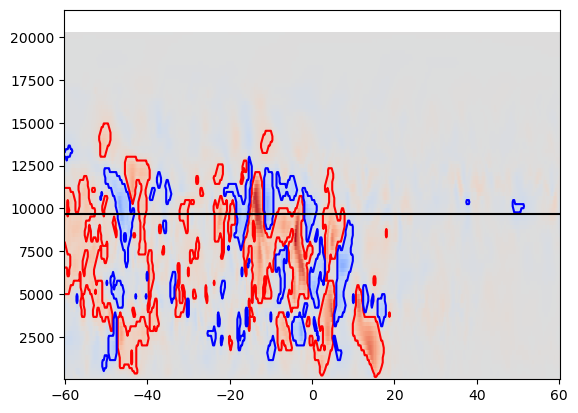

In [23]:
plt.pcolormesh(lon_m/1000., height, w_ca_comz[:,dx_dist,:], vmin=-25, vmax=25, cmap='coolwarm')
plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] > 3, colors = 'r')
plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] < -3, colors = 'b')
# plt.contour(lon_m/1000., height, 
#                cloudmask > 0,
#             colors='k')
plt.axhline(y=height[40], color='k', linestyle='-')

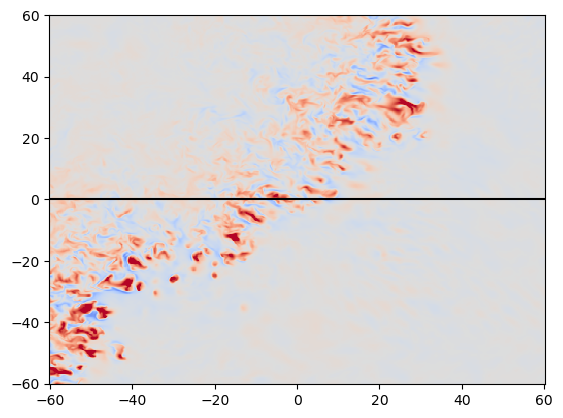

In [24]:
hh = 30
plt.pcolormesh(lat_m/1000., lon_m/1000., w_ca_comz[hh,:,:], vmin=-25, vmax=25, cmap='coolwarm')
# plt.contour(lat_m/1000., lon_m/1000., w_ca_comz[hh,:,:] > 3, colors = 'r')
# plt.contour(lat_m/1000., lon_m/1000., w_ca_comz[hh,:,:] < -3, colors = 'b')
plt.axhline(y=0, color='k', linestyle='-')

### Plot 3D watersheding example

In [25]:
# image = w_ca_comz[:,:,:] > 3
# distance = ndimage.distance_transform_edt(image)
# local_maxi = peak_local_max(
#     distance, footprint=np.ones((3, 3, 3)), labels=np.array(image),
#     min_distance=int(4000/dx_m[dx]), threshold_abs=1) # , indices=False

# peaks_mask = np.zeros_like(distance, dtype=bool)
# peaks_mask.T[local_maxi] = True

# markers = ndimage.label(peaks_mask)[0]

# labels = watersheding(np.array(image),  # 2D or 3D matrix with labeled objects [np.array]
#                  np.array(w_ca_comz[:,:,:]), # vertical wind field
#                    int(4000/dx_m[dx]),      # minimum distance between two objects [int]
#                    1)


In [26]:
# -----
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

image = w_ca_comz[:,:,:] > 3
coords = peak_local_max(np.array(w_ca_comz[:,:,:]), 
                        min_distance = int(2000/dx_m[dx]),
                        threshold_abs = 3*1.5,
                        labels = image
                       )
mask = np.zeros(w_ca_comz.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(image = np.array(w_ca_comz[:,:,:])*-1,  # watershedding field with maxima transformed to minima
                   markers = markers, # maximum points in 3D matrix
                   connectivity = np.ones((3, 3, 3)), # connectivity
                   offset = (np.ones((3)) * 1).astype('int'), #4000/dx_m[dx]).astype('int'),
                   mask = image, # binary mask for areas to watershed on
                   compactness = 0) # high values --> more regular shaped watersheds

start plotting
    ZOOM INTO CONVECTIVE RETION
    VERTICAL CROSS SECTION
        Plot map to: Example-core-segmentation_MCS_sgp_20120531_04:00:00_.jpg


mkdir: cannot create directory ‘’: No such file or directory


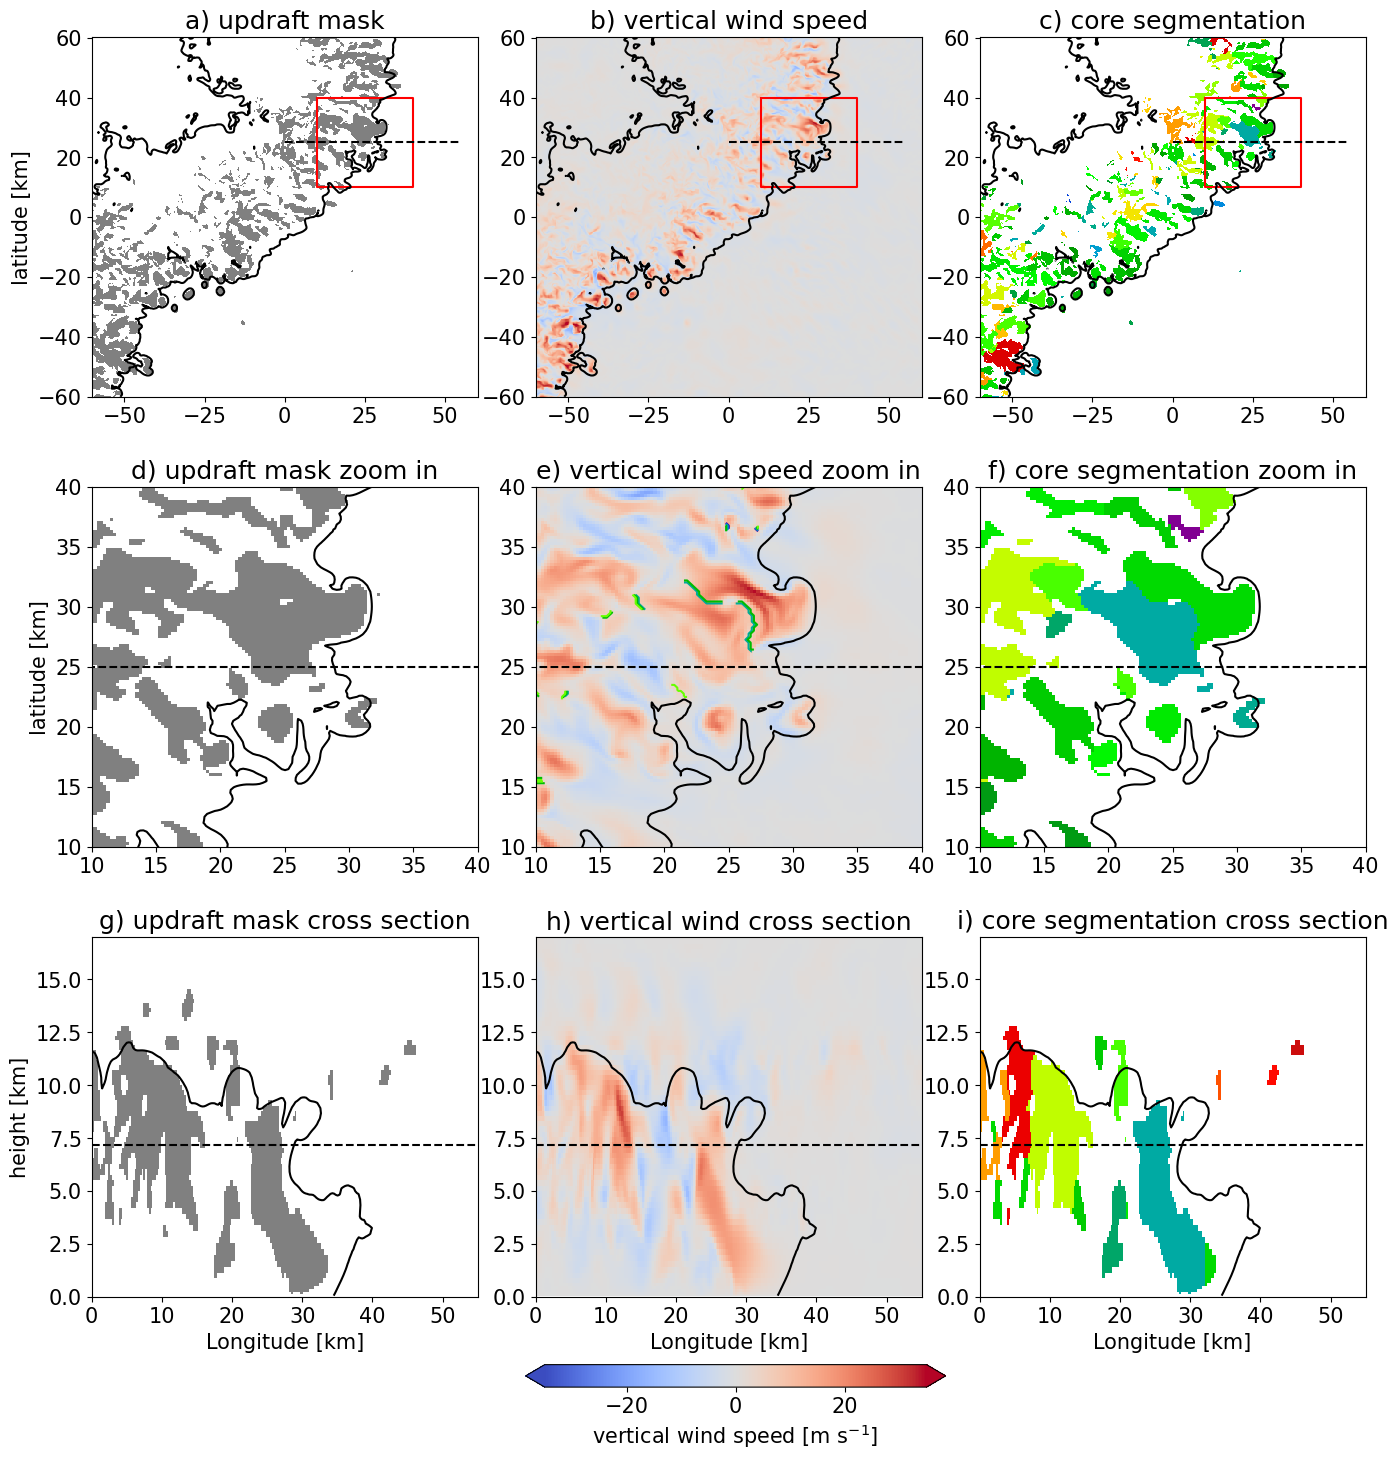

In [51]:
import numpy as np
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from scipy import ndimage

zz=30
lat_cut = np.argmin(np.abs(lon_m/1000. - 25))
dbz_min = 20



# # markers = ndimage.label(local_maxi)[0]
# labels_orig = watershed(-distance, markers, mask=image)
labels = np.copy(labels.astype(float))
labels[labels == 0] = np.nan


mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 15})

print('start plotting')

fig = plt.figure(figsize=(14,15))
# Histogram plots
gs1 = gridspec.GridSpec(3,3) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.13, top=0.97,
           wspace=0.15, hspace=0.25)

ax = plt.subplot(gs1[0,0])
plt.pcolormesh(lat_m/1000., lon_m/1000., image[zz,:,:]*-1, cmap='gray', vmin=-2, vmax=0)
plt.plot([10,40,40,10,10], [40,40,10,10,40], c='r')
plt.plot([0,55], [lon_m[lat_cut]/1000, lon_m[lat_cut]/1000], c='k', ls='--')
plt.contour(lat_m/1000., lon_m/1000., dbz_ca_comz[zz,:,:], colors = 'k', levels = [dbz_min])
plt.title('a) updraft mask')
ax.set_ylabel('latitude [km]')

ax = plt.subplot(gs1[0,1])
plt.pcolormesh(lat_m/1000., lon_m/1000., w_ca_comz[zz,:,:], vmin=-35, vmax=35, cmap='coolwarm')
plt.plot([10,40,40,10,10], [40,40,10,10,40], c='r')
plt.plot([0,55], [lon_m[lat_cut]/1000, lon_m[lat_cut]/1000], c='k', ls='--')
plt.contour(lat_m/1000., lon_m/1000., dbz_ca_comz[zz,:,:], colors = 'k', levels = [dbz_min])
plt.title('b) vertical wind speed')

ax = plt.subplot(gs1[0,2])
plt.pcolormesh(lat_m/1000., lon_m/1000., labels[zz,:,:], cmap=plt.cm.nipy_spectral, vmin=0, vmax=np.nanmax(labels))
plt.plot([10,40,40,10,10], [40,40,10,10,40], c='r')
plt.plot([0,55], [lon_m[lat_cut]/1000, lon_m[lat_cut]/1000], c='k', ls='--')
plt.contour(lat_m/1000., lon_m/1000., dbz_ca_comz[zz,:,:], colors = 'k', levels = [dbz_min])
plt.title('c) core segmentation')

# --------------------------------------------
print('    ZOOM INTO CONVECTIVE RETION')
tt1 = zz #tt - 0
ax = plt.subplot(gs1[1,0])
plt.pcolormesh(lat_m/1000., lon_m/1000., image[tt1,:,:]*-1, cmap='gray', vmin=-2, vmax=0)
plt.plot([0,55], [lon_m[lat_cut]/1000, lon_m[lat_cut]/1000], c='k', ls='--')
plt.contour(lat_m/1000., lon_m/1000., dbz_ca_comz[zz,:,:], colors = 'k', levels = [dbz_min])
plt.xlim(10, 40)
plt.ylim(10, 40)
ax.set_ylabel('latitude [km]')
plt.title('d) updraft mask zoom in')

ax = plt.subplot(gs1[1,1])
plt.pcolormesh(lat_m/1000., lon_m/1000., w_ca_comz[tt1,:,:], vmin=-35, vmax=35, cmap='coolwarm')
plt.plot([0,55], [lon_m[lat_cut]/1000, lon_m[lat_cut]/1000], c='k', ls='--')
plt.contour(lat_m/1000., lon_m/1000., dbz_ca_comz[zz,:,:], colors = 'k', levels = [dbz_min])
plt.xlim(10, 40)
plt.ylim(10, 40)
plt.contour(lat_m/1000., lon_m/1000., labels[tt1,:,:], cmap=plt.cm.nipy_spectral)
plt.title('e) vertical wind speed zoom in')

ax = plt.subplot(gs1[1,2])
plt.pcolormesh(lat_m/1000., lon_m/1000., labels[tt1,:,:], cmap=plt.cm.nipy_spectral, vmin=0, vmax=np.nanmax(labels))
plt.plot([0,55], [lon_m[lat_cut]/1000, lon_m[lat_cut]/1000], c='k', ls='--')
plt.contour(lat_m/1000., lon_m/1000., dbz_ca_comz[zz,:,:], colors = 'k', levels = [dbz_min])
plt.xlim(10, 40)
plt.ylim(10, 40)
plt.title('f) core segmentation zoom in')


# --------------------------------------------
print('    VERTICAL CROSS SECTION')


ax = plt.subplot(gs1[2,0])
plt.pcolormesh(lon_m/1000., height/1000, image[:,lat_cut,:]*-1, cmap='gray', vmin=-2, vmax=0)
plt.contour(lon_m/1000., height/1000, dbz_ca_comz[:,lat_cut,:], colors = 'k', levels = [dbz_min])
plt.axhline(y=height[zz]/1000, color='k', linestyle='--')
plt.ylim(0, 17)
plt.xlim(0, 55)
ax.set_xlabel('Longitude [km]')
ax.set_ylabel('height [km]')
plt.title('g) updraft mask cross section')

ax = plt.subplot(gs1[2,1])
cs = plt.pcolormesh(lon_m/1000., height/1000, w_ca_comz[:,lat_cut,:], cmap='coolwarm', vmin=-35, vmax=35)
plt.contour(lon_m/1000., height/1000, dbz_ca_comz[:,lat_cut,:], colors = 'k', levels = [dbz_min])
plt.axhline(y=height[zz]/1000, color='k', linestyle='--')
plt.ylim(0, 17)
plt.xlim(0, 55)
ax.set_xlabel('Longitude [km]')
plt.title('h) vertical wind cross section')

CbarAx = plt.axes([0.37, 0.07, 0.3, 0.015])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both') #, ticks=Levels)
cb.set_label('vertical wind speed [m s$^{-1}$]') #, fontsize=12)

ax = plt.subplot(gs1[2,2])
plt.pcolormesh(lon_m/1000., height/1000, labels[:,lat_cut,:], cmap=plt.cm.nipy_spectral, vmin=0, vmax=np.nanmax(labels))
plt.contour(lon_m/1000., height/1000, dbz_ca_comz[:,lat_cut,:], colors = 'k', levels = [dbz_min])
plt.axhline(y=height[zz]/1000, color='k', linestyle='--')
plt.ylim(0, 17)
plt.xlim(0, 55)
ax.set_xlabel('Longitude [km]')
plt.title('i) core segmentation cross section')


sPlotFile=''
sPlotName= 'Example-core-segmentation_MCS_'+SIM_All[si]+'.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight', dpi=700)

plt.show()

### Does 3D segmentation agree with 2D segmentation?

In [28]:
crossection_w = w_ca_comz[:,lat_cut,:]
image_2d = crossection_w > 3

coords = peak_local_max(np.array(w_ca_comz[:,lat_cut,:]), 
                        min_distance = int(2000/dx_m[dx]),
                        threshold_abs = 3*1.5,
                        labels = image_2d
                       )
mask = np.zeros(w_ca_comz[:,lat_cut,:].shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels_2d = watershed(image = np.array(w_ca_comz[:,lat_cut,:])*-1,  # watershedding field with maxima transformed to minima
                   markers = markers, # maximum points in 3D matrix
                   connectivity = np.ones((3, 3)), # connectivity
                   offset = (np.ones((2)) * 1).astype('int'), #4000/dx_m[dx]).astype('int'),
                   mask = image_2d, # binary mask for areas to watershed on
                   compactness = 0) # high values --> more regular shaped watersheds
labels_2d = labels_2d.astype('float')
labels_2d[labels_2d == 0] = np.nan

start plotting
    VERTICAL CROSS SECTION


mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: Example-core-segmentation_MCS_sgp_20120531_04:00:00_.jpg


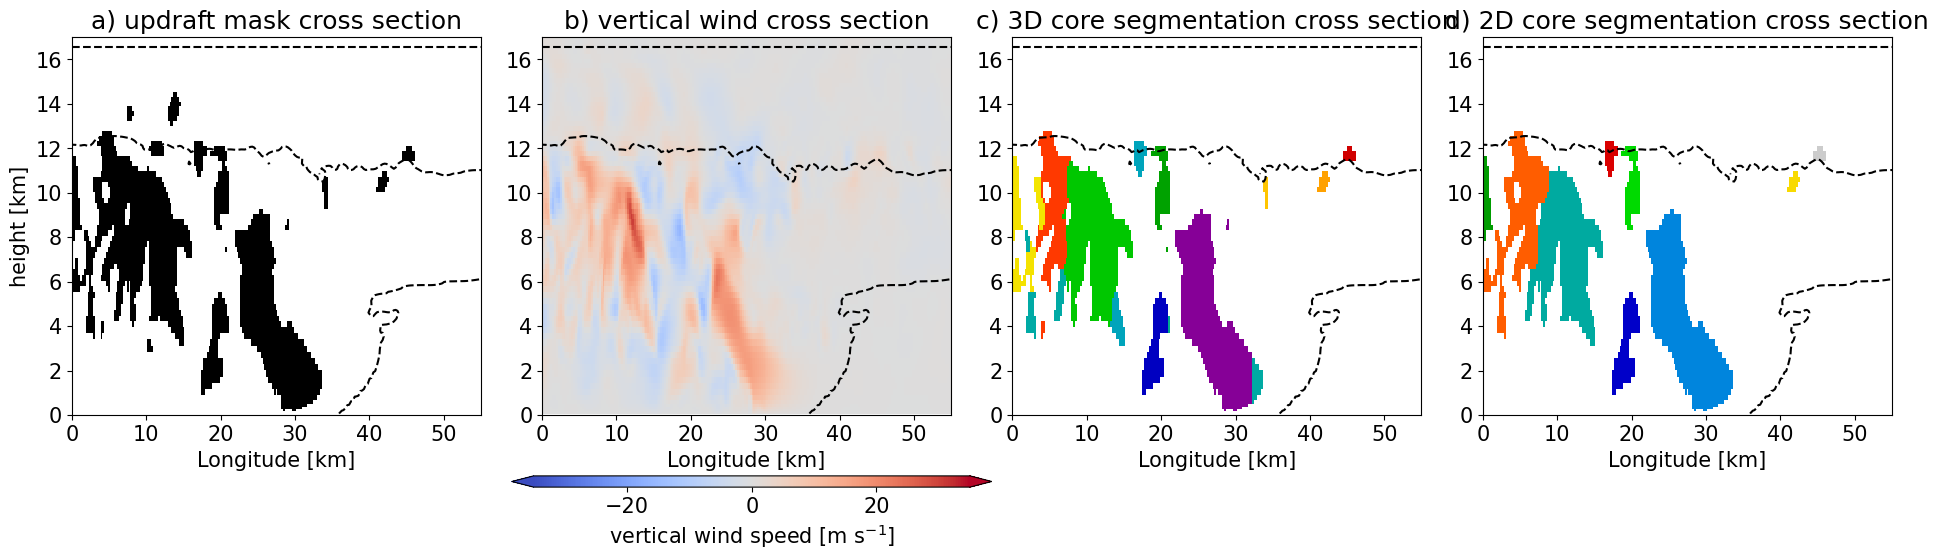

In [29]:
import numpy as np
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from scipy import ndimage

zz=30
lat_cut = np.argmin(np.abs(lon_m/1000. - 25))




# # markers = ndimage.label(local_maxi)[0]
# labels_orig = watershed(-distance, markers, mask=image)
labels = np.copy(labels.astype(float))
labels[labels == 0] = np.nan


mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 15})

print('start plotting')

fig = plt.figure(figsize=(20,4.5))
# Histogram plots
gs1 = gridspec.GridSpec(1,4) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.13, top=0.97,
           wspace=0.15, hspace=0.25)

# --------------------------------------------
print('    VERTICAL CROSS SECTION')


ax = plt.subplot(gs1[0,0])
plt.pcolormesh(lon_m/1000., height/1000, image[:,lat_cut,:]*-1, cmap='gray')
plt.contour(lon_m/1000., height/1000, dbz_ca_comz[:,lat_cut,:], colors = 'k', levels = [-20])
plt.axhline(y=height[tt]/1000, color='k', linestyle='--')
plt.ylim(0, 17)
plt.xlim(0, 55)
ax.set_xlabel('Longitude [km]')
ax.set_ylabel('height [km]')
plt.title('a) updraft mask cross section')

ax = plt.subplot(gs1[0,1])
cs = plt.pcolormesh(lon_m/1000., height/1000, w_ca_comz[:,lat_cut,:], cmap='coolwarm', vmin=-35, vmax=35)
plt.contour(lon_m/1000., height/1000, dbz_ca_comz[:,lat_cut,:], colors = 'k', levels = [-20])
plt.axhline(y=height[tt]/1000, color='k', linestyle='--')
plt.ylim(0, 17)
plt.xlim(0, 55)
ax.set_xlabel('Longitude [km]')
plt.title('b) vertical wind cross section')

CbarAx = plt.axes([0.28, -0.03, 0.24, 0.025])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both') #, ticks=Levels)
cb.set_label('vertical wind speed [m s$^{-1}$]') #, fontsize=12)

ax = plt.subplot(gs1[0,2])
plt.pcolormesh(lon_m/1000., height/1000, labels[:,lat_cut,:], cmap=plt.cm.nipy_spectral) #, vmin=0, vmax=np.nanmax(labels))
plt.contour(lon_m/1000., height/1000, dbz_ca_comz[:,lat_cut,:], colors = 'k', levels = [-20])
plt.axhline(y=height[tt]/1000, color='k', linestyle='--')
plt.ylim(0, 17)
plt.xlim(0, 55)
ax.set_xlabel('Longitude [km]')
plt.title('c) 3D core segmentation cross section')


ax = plt.subplot(gs1[0,3])
plt.pcolormesh(lon_m/1000., height/1000, labels_2d[:,:], cmap=plt.cm.nipy_spectral, vmin=0) #, vmax=np.nanmax(labels_2d))
plt.contour(lon_m/1000., height/1000, dbz_ca_comz[:,lat_cut,:], colors = 'k', levels = [-20])
plt.axhline(y=height[tt]/1000, color='k', linestyle='--')
plt.ylim(0, 17)
plt.xlim(0, 55)
ax.set_xlabel('Longitude [km]')
plt.title('d) 2D core segmentation cross section')


sPlotFile=''
sPlotName= 'Example-core-segmentation_MCS_'+SIM_All[si]+'.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight', dpi=700)

plt.show()